# GPU Computing - Exercise 4
## Eetu Knutars
## 29.1.2025

# Task 1
Both NumPy and CuPy offer the linear algebra functions  linalg.norm() to get the norm and linalg.qr() to get the QR decomposition of matrices.

Time their performance against different sizes of square matrices.


Importing libraries

In [2]:
import cupy as cp
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline

Testing NumPy and CuPy performance for calculating matrix norm

Text(0, 0.5, 'Time [ms]')

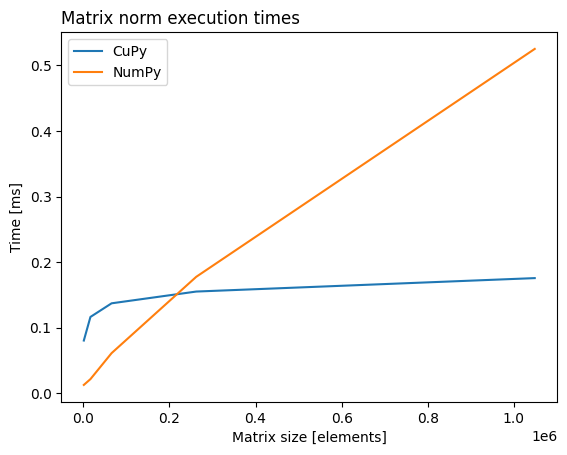

In [11]:
matrix_sizes = np.array([32, 128, 256, 512, 1024])
number_tests = 100

f_gpu_times = []
f_cpu_times = []

for matrix_size in matrix_sizes:
  gpu_times = []
  cpu_times = []

  for _ in range(number_tests):

    # Create random matrices in CPU and GPU
    x_gpu = cp.random.rand(matrix_size, matrix_size)
    x_cpu = np.random.rand(matrix_size, matrix_size)

    # Do the norm in GPU
    start = time.time()
    cp.linalg.norm(x_gpu)
    gpu_times.append(time.time() - start)

    # Do the norm in CPU
    start = time.time()
    np.linalg.norm(x_cpu)
    cpu_times.append(time.time() - start)

  f_gpu_times.append(1000*np.mean(gpu_times))
  f_cpu_times.append(1000*np.mean(cpu_times))

plt.plot(matrix_sizes**2, f_gpu_times, label="CuPy")
plt.plot(matrix_sizes**2, f_cpu_times, label="NumPy")
plt.legend()
plt.title("Matrix norm execution times", loc="left")
plt.xlabel("Matrix size [elements]")
plt.ylabel("Time [ms]")

From the plot it can be seen that with small matrices CPU performs better but when element count rises above ~200000 then GPU catches up on performance.

Testing NumPy and CuPy performance for calculating QR decomposition

Text(0, 0.5, 'Time [ms]')

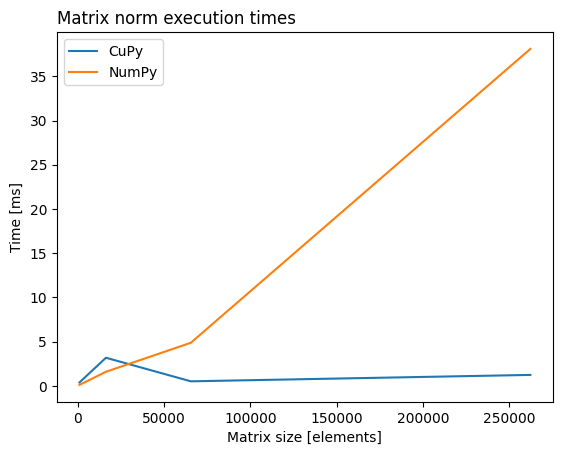

In [13]:
matrix_sizes = np.array([32, 128, 256, 512, 1024])
number_tests = 100

f_gpu_times = []
f_cpu_times = []

for matrix_size in matrix_sizes:
  gpu_times = []
  cpu_times = []

  for _ in range(number_tests):

    # Create random matrices in CPU and GPU
    x_gpu = cp.random.rand(matrix_size, matrix_size)
    x_cpu = np.random.rand(matrix_size, matrix_size)

    # Do the norm in GPU
    start = time.time()
    cp.linalg.qr(x_gpu)
    gpu_times.append(time.time() - start)

    # Do the norm in CPU
    start = time.time()
    np.linalg.qr(x_cpu)
    cpu_times.append(time.time() - start)

  f_gpu_times.append(1000*np.mean(gpu_times))
  f_cpu_times.append(1000*np.mean(cpu_times))

plt.plot(matrix_sizes**2, f_gpu_times, label="CuPy")
plt.plot(matrix_sizes**2, f_cpu_times, label="NumPy")
plt.legend()
plt.title("QR decomposition execution times", loc="left")
plt.xlabel("Matrix size [elements]")
plt.ylabel("Time [ms]")

From the plot it can be seen that with small matrices CPU performs slightly better but when element count rises above ~30000 then GPU catches up on performance and the difference between GPU and CPU performance gets pretty clear.

# Task 2
Implement vector addition using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different vector sizes.

In [1]:
import cupy as cp
import numpy as np
import math
import time
from matplotlib import pyplot as plt
%matplotlib inline

Function for calculating diff using RawKernel and shared memory

In [7]:

def diff_kernel(input_array):
    # Define the CUDA kernel for differentiation using shared memory
    our_kernel = cp.RawKernel(r''' extern "C"
    #define SHARED_DIM 1025

    __global__ void vecdiff(const double *xs, double* dxs, int size)
    {
        __shared__ double s_xs[SHARED_DIM];

        int tx = threadIdx.x;
        int index = tx + blockDim.x * blockIdx.x;


        // Check that we are inside the data indices.
        if(index < (size - 1)){

        // To be able to process the elements on the borders of the blocks we copy the first element separately.
            if(tx == 0) s_xs[tx] = xs[index];

        // Copy the block of data to the shared memory.
            s_xs[tx + 1] = xs[index + 1];


        // Wait for all of the threads to finish the copy.
            __syncthreads();

        // Subtract the neighbouring elements to the output vector.
            dxs[index] = s_xs[tx + 1] - s_xs[tx];
        }
    }
    ''', 'vecdiff')

    vector_size = input_array.size

    numThreadsPerBlock = 1024
    numBlocks = math.ceil(vector_size/numThreadsPerBlock)

    # Create output vector
    output = cp.zeros(vector_size-1, dtype=np.float64)

    # Call the kernel
    our_kernel((numBlocks,1,1),(numThreadsPerBlock,1,1), (input_array, output, np.int32(vector_size)))

    return output

Text(0, 0.5, 'Time [ms]')

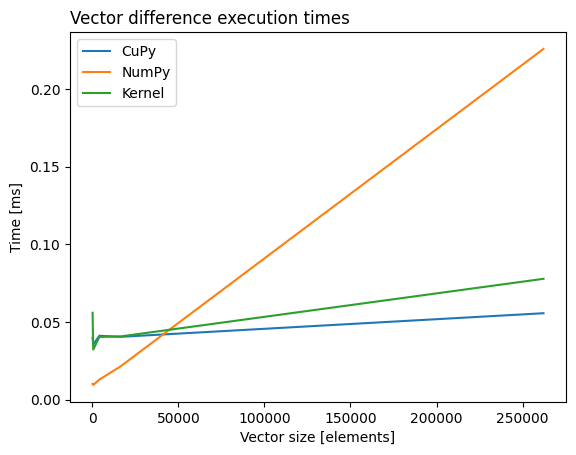

In [13]:
vector_sizes = np.array([2**7, 2**9, 2**12, 2**14, 2**18])
number_tests = 100

f_cupy_times = []
f_numpy_times = []
f_kernel_times = []

for vector_size in vector_sizes:
  numpy_times = []
  cupy_times = []
  kernel_times = []

  for _ in range(number_tests):

    # Create random vectors in CPU and GPU
    x_gpu = cp.random.rand(vector_size)
    x_cpu = np.random.rand(vector_size)

    # Do the diff in CuPy
    start = time.time()
    cp.diff(x_gpu)
    cupy_times.append(time.time() - start)

    # Do the diff in NumPy
    start = time.time()
    np.diff(x_cpu)
    numpy_times.append(time.time() - start)

    # Do the diff in kernel
    start = time.time()
    diff_kernel(x_gpu)
    kernel_times.append(time.time() - start)

  f_cupy_times.append(1000*np.mean(cupy_times))
  f_numpy_times.append(1000*np.mean(numpy_times))
  f_kernel_times.append(1000*np.mean(kernel_times))

# Visualization
plt.plot(vector_sizes, f_cupy_times, label="CuPy")
plt.plot(vector_sizes, f_numpy_times, label="NumPy")
plt.plot(vector_sizes, f_kernel_times, label="Kernel")
plt.legend()
plt.title("Vector difference execution times", loc="left")
plt.xlabel("Vector size [elements]")
plt.ylabel("Time [ms]")

From the plot we can see that NumPy execution time increases drastically when increasing the vector size. However if vector size is <50000 then CPU performs better, so with short arrays its more benefitial to use it. CuPys own diff function performs slightly better than the shared memory kernel.

# Task 3
Implement matrix multiplication using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different matrix sizes.

Importing libraries

In [17]:
import cupy as cp
import numpy as np
import math
import time
from matplotlib import pyplot as plt
%matplotlib inline

Function for calculating matrix multiplication using a kernel. I'm using shared memory kernel from the solution for Exercise 2.

In [23]:
def matrix_multiplication_kernel(A, B):
    our_kernel = cp.RawKernel(r''' extern "C"
    #define TILE_DIM 32

    __global__ void matrix_multiplication_shared_memory(const double* A, const double* B, double* C, int N, int M, int K)
    {

        // Allocate the sub-matrices to the shared memory. Note two-dim indexing.
        __shared__ double sub_A[TILE_DIM][TILE_DIM];
        __shared__ double sub_B[TILE_DIM][TILE_DIM];

        const int tx = threadIdx.x;
        const int ty = threadIdx.y;

        const int bx = blockIdx.x;
        const int by = blockIdx.y;

        // Each block gets it own TILE_DIM sized slot in x and y directions.
        const int row = by * TILE_DIM + ty;
        const int col = bx * TILE_DIM + tx;

        double result = 0.0;

        for(int i = 0; i <  M  / TILE_DIM; i++)
            {

            // Iterate over the tile dimension to copy the data.
            sub_A[ty][tx] = A[(i * TILE_DIM + tx) + M * row];
            sub_B[ty][tx] = B[(i * TILE_DIM + ty) * K + col];

            // Make sure that all threads have completed the memory transaction.
            __syncthreads();

            // Multiply the matrix elements inside the tile and add them to the result.
            for (int j = 0; j < TILE_DIM; j++)
                {
                result += sub_A[ty][j] * sub_B[j][tx];
                }

            // Make sure that all of the threads have finished the calculation
            __syncthreads();
            }

        // Write back to the global memory. Using the global index.
        int C_index = K * (by * blockDim.y + ty) + (bx * blockDim.x + tx);
        C[C_index] = result;
    }
    ''', 'matrix_multiplication_shared_memory')

    N = A.shape[0]
    M = A.shape[1]
    K = B.shape[1]

    C_n_rows = N
    C_n_cols = K

    value_type = cp.float64

    # Define the block and grid sizes
    numThreadsPerBlock = 32
    numBlocksx = math.ceil(C_n_cols/numThreadsPerBlock)
    numBlocksy = math.ceil(C_n_rows/numThreadsPerBlock)

    C = cp.zeros([C_n_rows,C_n_cols])

    A = A.astype(value_type)
    B = B.astype(value_type)
    C = C.astype(value_type)

    # Call the CUDA kernel for matrix multiplication
    our_kernel((numBlocksx, numBlocksy,1),(numThreadsPerBlock,numThreadsPerBlock, 1),(A, B, C, np.int32(N), np.int32(M), np.int32(K)))

    return C

Text(0, 0.5, 'Time [ms]')

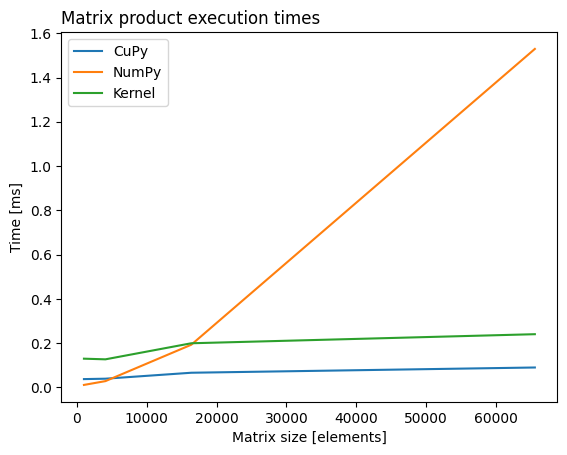

In [25]:
matrix_sizes = np.array([32, 64, 128, 256])
number_tests = 100

f_cupy_times = []
f_numpy_times = []
f_kernel_times = []

for matrix_size in matrix_sizes:
  cupy_times = []
  numpy_times = []
  kernel_times = []

  for _ in range(number_tests):

    # Create random matrices in CPU and GPU
    A_gpu = cp.random.rand(matrix_size, matrix_size)
    B_gpu = cp.random.rand(matrix_size, matrix_size)
    A_cpu = np.random.rand(matrix_size, matrix_size)
    B_cpu = np.random.rand(matrix_size, matrix_size)

    # Do the product in CuPy
    start = time.time()
    cp.dot(A_gpu, B_gpu)
    cupy_times.append(time.time() - start)

    # Do the product in NumPy
    start = time.time()
    np.dot(A_cpu, B_cpu)
    numpy_times.append(time.time() - start)

    # Do the product in kernel
    start = time.time()
    matrix_multiplication_kernel(A_gpu, B_gpu)
    kernel_times.append(time.time() - start)

  # Update the average times for the given matrix size
  f_cupy_times.append(1000*np.mean(cupy_times))
  f_numpy_times.append(1000*np.mean(numpy_times))
  f_kernel_times.append(1000*np.mean(kernel_times))

# Visualization
plt.plot(matrix_sizes**2, f_cupy_times, label="CuPy")
plt.plot(matrix_sizes**2, f_numpy_times, label="NumPy")
plt.plot(matrix_sizes**2, f_kernel_times, label="Kernel")
plt.legend()
plt.title("Matrix product execution times", loc="left")
plt.xlabel("Matrix size [elements]")
plt.ylabel("Time [ms]")

From the plot we can see that NumPy execution time increases drastically when increasing the matrix size. CuPys own dot function performs slightly better than the shared memory kernel.